<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
from bs4 import BeautifulSoup
import requests

df = pd.read_csv('data/job_listings.csv', index_col=0)

In [3]:
# Define a function to clean html tags

def clean_description(desc):
    bytes = eval(desc)
    soup = BeautifulSoup(bytes, 'html.parser')
    return soup.get_text()

# Use it
df['clean_desc'] = df['description'].apply(clean_description)

# Remove "newline" characters
df['clean_desc'] = df['clean_desc'].replace(r'\n',' ', regex=True)

# Remove unicode
df['clean_desc'] = df['clean_desc'].apply(lambda x: x.encode('ascii', 'ignore').strip())

# Convert description from bytes to string
df['clean_desc'] = df['clean_desc'].str.decode("utf-8")
df.head()

,description,title,clean_desc
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: Conceptual understanding in ...
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description As a Data Scientist 1, you wi..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA multiple locations 2+ years of ...


## 2) Use Spacy to tokenize the listings 

In [11]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# The Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Make the tokens
tokens = []
for desc in tokenizer.pipe(df['clean_desc'], batch_size=500):
    desc_tokens = [token.text for token in desc]
    tokens.append(desc_tokens)
df['tokens'] = tokens
df['tokens'].head()

0    [Job, Requirements:, Conceptual, understanding...
1    [Job, Description,  , As, a, Data, Scientist, ...
2    [As, a, Data, Scientist, you, will, be, workin...
3    [$4,969, -, $6,756, a, monthContractUnder, the...
4    [Location:, USA,  , multiple, locations, 2+, y...
Name: tokens, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the transformer
vect = CountVectorizer(stop_words='english')

# Build vocab
vect.fit(df['clean_desc'])

# Transform text
dtm = vect.transform(df['clean_desc'])

# Sparse Matrix
dtm.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 2, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]])

In [13]:
# Get word counts for each listing
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,00,000,02115,03,0305,0356,04,062,06366,08,...,zf,zfs,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich,zurichs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [15]:
def count(data, n=None):
    """
    List the top n words in a vocabulary
    """
    vect = CountVectorizer(stop_words='english')
    vect.fit(data)
    dtm = vect.transform(data)
    sum_words = dtm.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

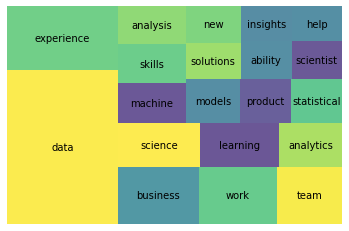

In [16]:
import squarify
import matplotlib.pyplot as plt

top20_words = pd.DataFrame(count(df['clean_desc'], n=20), columns=['word', 'count'])

squarify.plot(sizes=top20_words['count'], label=top20_words['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [17]:
# tokenizer function using a spacy nlp object
def tokenize(text):
    txt = nlp(text)
    return [token.lemma_.strip() for token in txt if (token.is_stop != True) and (token.is_punct != True)]

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=0.003)

# Create a vocabulary and get word counts per listing
dtm = tfidf.fit_transform(df['clean_desc'])

# Get feature names to use a dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,00,000,03,04,06366,10,100,1001,105,1079302,...,york,youll,young,youre,youve,yrs,zero,zf,zfs,zogsports
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [19]:
from sklearn.neighbors import NearestNeighbors

# Fit on dtm
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [20]:
# Query Using kneighbors 
nn.kneighbors([dtm.iloc[0]])

(array([[0.        , 1.27537194, 1.2842154 , 1.31030399, 1.31431452]]),
 array([[  0, 276, 274, 115, 366]]))

In [21]:
df['clean_desc'][0]

"Job Requirements: Conceptual understanding in Machine Learning models like Naive Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role) Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R Ability to communicate Model findings to both Technical and Non-Technical stake holders Hands on experience in SQL/Hive or similar programming language Must show past work via GitHub, Kaggle or any other published article Master's degree in Statistics/Mathematics/Computer Science or any other quant specific field. Apply Now"

In [22]:
df['clean_desc'][276]

"Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities  we're just getting started. The Infrastructure Strategy group is responsible for the strategic analysis to support and enable the continued growth critical to Facebooks infrastructure organization. The ideal candidate will be passionate about Facebook, have strong analytical and modeling aptitude and has experience usi

In [23]:
ideal_ds_position = ["""
The ideal entry-level data science position has responsibilities spanning the breadth of the data science stack and functionality, with mentorship and growth opportunities and the ability to become more familiar with data engineering, machine learning, and deep learning initiatives.
"""]

In [25]:
# Query the ideal job
new = tfidf.transform(ideal_ds_position)
nn.kneighbors(new.todense())

(array([[1.32977803, 1.32977803, 1.33178269, 1.33465414, 1.33465414]]),
 array([[ 47, 100, 151,  52, 142]]))

In [27]:
# Inspect most relevant job
df['clean_desc'][47]

"Description A rare opportunity to join the development division within Information Systems at Steward Health Care, the top leader in the competitive for-profit hospital industry. We are seeking a motivated and experienced Data Scientist to contribute to the software development initiatives that improve the quality of health care across the country. This individual will be working with programmers, analysts and senior level management to optimize the development process within the enterprise by expanding our existing predictive analytics field. Key Responsibilities Conduct research and build actionable visualizations that drive decisions. Collect data required to extract actionable insights. Work with the subject matter experts and key stakeholders to understand end goals for enhancements and new predictive tools. Values critical thinking and has the ability to solve complex problems with incomplete data and a genuine curiosity. Contribute to the team's overall knowledge by educating c

In [29]:
# Inspect 2nd most relevant job (100 was the same as 47)
df['clean_desc'][151]

'The Data Scientist is a critical position within DSS and in the Data organization who specializes in applying machine learning methods to meet optimization, personalization, recommendations and efficiency related challenges, in close collaboration with engineering and business partners. In this role, you will build and apply machine learning techniques and modern statistics to data both augment decision-making but to also significantly improve operational process problems through automation. You will collaborate across teams to define problems and develop automated solutions with the Data, Product and Engineering teams to be built into our products.  Responsibilities : Reframe objectives as machine learning tasks that can deliver actionable insights, accurate predictions, and effective optimization. Implement and execute machine learning with reliability and reproducibility. Explain how models and systems work to both non-technical and technical stakeholders. Collaborate with engineer

In [30]:
# Inspect 2nd most relevant job
df['clean_desc'][52]

"The challenge Adobe is looking for a Senior Data Scientist who will be building the next generation of marketing cloud products by leveraging machine learning, predictive modeling and optimization techniques. These products would help businesses understand, manage, and optimize the experience throughout the customer journey. Example applications include real-time online media optimization, media attribution, predictive sales analytics, product recommendation, mobile analytics, predictive customer scoring and segmentation and large-scale experimentation. Ideal candidates will have a strong academic background as well as technical skills including applied statistics, machine learning, data mining, and software development. Familiarity working with large-scale datasets and big data techniques would be a plus. What youll do Develop predictive models on large-scale datasets to address various business problems through leveraging advanced statistical modeling, machine learning, data mining 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 